In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import random
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [2]:
def generate_random_mn(M, N, num_pairs):
    special_mn = set()
    while len(special_mn) < num_pairs:
        m = random.randint(0, M-1)
        n = random.randint(0, N-1)
        special_mn.add((m, n))
    return list(special_mn)

In [3]:
M = 364
N = 91
w = 0.0025
l = 0.0025

In [4]:
def create_tandem_array(M, N, special_mn):
    
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.62e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 1.675@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            is_special = (m, n) in special_mn
            
            # Metal Sheet Resistance
            if m == 0:
                circuit.R(f'Metal_sheet_input{n:03d}', 'input', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm).plus.add_current_probe(circuit)
            if ( m == 1 and 0 < n < 91) or (m > 1 and  n == 45):
                circuit.R(f'Metal_sheet_v{m:03d}{n:03d}', f'q{m-1:03d}{n:03d}', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm).plus.add_current_probe(circuit)
                circuit.R(f'Metal_sheet_h{m:03d}{n:03d}', f'q{m:03d}{n-1:03d}', f'q{m:03d}{n:03d}', 2.13*w/l@u_mOhm).plus.add_current_probe(circuit)
                circuit.R(f'c_metal_{name_prefix}', f'q{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 5/(w*l)@u_mOhm).plus.add_current_probe(circuit)            
            
                
            # ITO Sheet Resistance
            
            if m > 0:
                circuit.R(f'ITO_sheet_v{m:03d}{n:03d}', f'a{m-1:03d}{n:03d}', f'a{m:03d}{n:03d}', 55*l/w@u_Ohm).plus.add_current_probe(circuit)
            if n > 0:
                circuit.R(f'ITO_sheet_h{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', 55*w/l@u_Ohm).plus.add_current_probe(circuit)

            # RJ Sheet Resistance
            if m > 0:
                circuit.R(f'RJ_sheet_v{m:03d}{n:03d}', f'd{m-1:03d}{n:02d}', f'd{m:03d}{n:03d}', 200*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'RJ_sheet_h{m:03d}{n:03d}', f'd{m:03d}{n-1:03d}', f'd{m:03d}{n:03d}', 200*w/l@u_Ohm)

            # Top Cell
            
            if is_special:
                circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm).plus.add_current_probe(circuit)   
            else:
                circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2/(w*l)@u_Ohm).plus.add_current_probe(circuit)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top')
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top')
            circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
                
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

            # Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0/(w*l)@u_mOhm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0/(w*l)@u_mOhm)

            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot')
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot')
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

    return circuit

In [5]:
num_pairs = 0 
special_mn = generate_random_mn(M, N, num_pairs)
circuit = create_tandem_array(M, N, special_mn)
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
 
%time analysis = simulator.operating_point()

CPU times: total: 6min 58s
Wall time: 6min 58s


In [13]:
print("Loss Fraction Calculation in Unit Cell\n")

rs_top_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        rs_top_branch_name = f'vrs_top_{m:03d}{n:03d}_plus'
        if rs_top_branch_name in analysis.branches:
            rs_top_current = analysis.branches[rs_top_branch_name][0]
            rs_top_resistance = 2/(w*l)
            rs_top_power_loss = float(rs_top_current * rs_top_current * rs_top_resistance)
            rs_top_total_power_loss += rs_top_power_loss
            
            
metal_sheet_input_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        metal_sheet_input_branch_name = f'vrmetal_sheet_input{n:03d}_plus'
        if metal_sheet_input_branch_name in analysis.branches:
            metal_sheet_input_current = analysis.branches[metal_sheet_input_branch_name][0]
            metal_sheet_input_resistance = (2.13*(l/w))*0.001
            metal_sheet_input_power_loss = float(metal_sheet_input_current * metal_sheet_input_current * metal_sheet_input_resistance)
            metal_sheet_input_total_power_loss += metal_sheet_input_power_loss
            
metal_sheet_v_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        metal_sheet_v_branch_name = f'vrmetal_sheet_v{m:03d}{n:03d}_plus'
        if metal_sheet_v_branch_name in analysis.branches:
            metal_sheet_v_current = analysis.branches[metal_sheet_v_branch_name][0]
            metal_sheet_v_resistance = (2.13*(l/w))*0.001
            metal_sheet_v_power_loss = float(metal_sheet_v_current * metal_sheet_v_current * metal_sheet_v_resistance)
            metal_sheet_v_total_power_loss += metal_sheet_v_power_loss
            
metal_sheet_h_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        metal_sheet_h_branch_name = f'vrmetal_sheet_v{m:03d}{n:03d}_plus'
        if metal_sheet_h_branch_name in analysis.branches:
            metal_sheet_h_current = analysis.branches[metal_sheet_h_branch_name][0]
            metal_sheet_h_resistance = (2.13*(w/l))*0.001
            metal_sheet_h_power_loss = float(metal_sheet_h_current * metal_sheet_h_current * metal_sheet_h_resistance)
            metal_sheet_h_total_power_loss += metal_sheet_h_power_loss
            
c_metal_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        c_metal_branch_name = f'vrc_metal_{m:03d}{n:03d}_plus'
        if c_metal_branch_name in analysis.branches:
            c_metal_current = analysis.branches[c_metal_branch_name][0]
            c_metal_resistance = (5/(w*l))*0.001
            c_metal_power_loss = float(c_metal_current * c_metal_current * c_metal_resistance)
            c_metal_total_power_loss += c_metal_power_loss
            
ito_sheet_v_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        ito_sheet_v_branch_name = f'vrito_sheet_v{m:03d}{n:03d}_plus'
        if ito_sheet_v_branch_name in analysis.branches:
            ito_sheet_v_current = analysis.branches[ito_sheet_v_branch_name][0]
            ito_sheet_v_resistance = 55*(l/w)
            ito_sheet_v_power_loss = float(ito_sheet_v_current * ito_sheet_v_current * ito_sheet_v_resistance)
            ito_sheet_v_total_power_loss += ito_sheet_v_power_loss
            
            
ito_sheet_h_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        ito_sheet_h_branch_name = f'vrito_sheet_h{m:03d}{n:03d}_plus'
        if ito_sheet_h_branch_name in analysis.branches:
            ito_sheet_h_current = analysis.branches[ito_sheet_h_branch_name][0]
            ito_sheet_h_resistance = 55*(w/l)
            ito_sheet_h_power_loss = float(ito_sheet_h_current * ito_sheet_h_current * ito_sheet_h_resistance)
            ito_sheet_h_total_power_loss += ito_sheet_h_power_loss

            
finger_loss = metal_sheet_input_total_power_loss + metal_sheet_v_total_power_loss + metal_sheet_h_total_power_loss
contact_loss = c_metal_total_power_loss
ito_loss = ito_sheet_v_total_power_loss + ito_sheet_h_total_power_loss
rs_top_loss = rs_top_total_power_loss

total_loss = finger_loss + contact_loss + ito_loss + rs_top_loss
finger_fraction = (finger_loss/total_loss)*100
contact_fraction = (contact_loss/total_loss)*100
ito_fraction = (ito_loss/total_loss)*100
rs_top_fraction = (rs_top_loss/total_loss)*100

print(f"Finger loss fraction: {finger_fraction:.4f}%")
print(f"Contact loss fraction: {contact_fraction:.4f}%")
print(f"ITO loss fraction: {ito_fraction:.4f}%")
print(f"Rs_top loss fraction: {rs_top_fraction:.4f}%")

Loss Fraction Calculation in Unit Cell

Finger loss fraction: 4.4562%
Contact loss fraction: 14.4240%
ITO loss fraction: 8.3057%
Rs_top loss fraction: 72.8142%


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import math
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [21]:
M = 20
N = 80
w = 0.91
l = 0.2275

In [22]:
# Setting Parameters

Jmppa = 19.32*10    # current density mA/cm2*10 -> A/m2
Vmppa = 1.675   # Voc active cell

a =  9.1e-3        #unit cell width in m
s =  2.275e-3       # finger spacing
wf = 25e-6      #finger width
Lf = 9.05e-3       # finger length
Lb = 18.2e-2    # bus bar length (cell size)

Rsh = 55     # emitter sheet resistance in Ohm/sq
Rsk = 55    # sheet resistance under contact

rhoc = 5e-7  # contact resistance in Ohm.m2
rhof = 3.2e-8   # finger line resistivity
rhob = 3.2e-8   # busbar resistivity
rhot = 0e-8   # tab resistivity

hf = 15e-6    # finger height
Af = hf*wf    # finger cross-section area
hb = 15e-6    # busbar height
wb = 0.1e-3     # busbar width
wbuc = wb*0.5 # busbar width in unit cell

Ns = 10       # number of soldering point
b = Lb/(Ns*2)     # width of unit cell #2
ht = 500e-6   # tab height
wt = wb       # tab width

def coth(x):
    return 1 / math.tanh(x)

# Shading losses
ps_bus = s*wbuc/(s*a)
ps_f = Lf*wf/(s*a)
ps_tot = ps_bus + ps_f      # power loss by shading

# Normalized resistance by emitter, emitter contact, finger
r_e = (1/12*Rsh*(s-wf)/Lf*a*s)
r_ec = (math.sqrt(Rsk*rhoc)/Lf)*coth((wf/2)*math.sqrt(Rsk/rhoc))*a*(s/2)
r_f = (1/3*rhof*Lf/Af*a*s)

# Normalized resistance by busbar, tab
r_bus = (1/3*rhob*b**2/(hb*wbuc)*a)
r_tab = (2/3*rhot*a*Lb**2/(ht*wt)*(1+1/(2*Ns**2)))


r1 = r_e + r_ec + r_f;   #electrical resistance by emitter, emitter contact, finger (no busbar)

p_ef = ((1 - ps_tot)**2)*r_f*(Jmppa/Vmppa)
p_ec = ((1 - ps_tot)**2)*r_ec*(Jmppa/Vmppa)
p_e = ((1 - ps_tot)**2)*r_e*(Jmppa/Vmppa)
p_e1 = ((1 - ps_tot)**2)*r1*(Jmppa/Vmppa)

p_ec = ((1 - ps_tot)**2)*r_ec*(Jmppa/Vmppa) #electrical power loss by emitter, emitter contact, finger bar
p_tot1 = p_e1 + ps_tot   # power loss electrical loss by emitter, emitter contact, finger + shading loss of finger and busbar

p_eb = ((1 - ps_tot)**2)*r_bus*(Jmppa/Vmppa) # electrical loss by bus bar
p_et = ((1 - ps_tot)**2)*r_tab*(Jmppa/Vmppa) # electrical loss by tab

p_tot2 = p_tot1 + p_eb + p_et;      # total power loss including electrical losses of bus bar & tab.

nr_bus = rhob/hb # Sheet resistance of busbar
nr_tab = rhot/ht # Sheet resistance of tab
nr_ec = rhoc*10**4 # Emitter contact resistance
nr_f = rhof/hf # Sheet resistance of finger
nr_e = Rsh #Emitter sheet resistance

print("Normalized Parameters")
print(f"emitter sheet resistance: {nr_e:.4f}(Ohm/sq)")
print(f"emitter contact resistance: {nr_ec:.4f}(Ohm*cm^2)")
print(f"finger sheet resistance: {nr_f*1000:.4f}(mOhm/sq)")
print(f"busbar sheet resistance: {nr_bus*1000:.4f}(mOhm/sq)")
print(f"tab sheet resistance: {nr_tab*1000:.4f}(mOhm/sq)")
print("\n\n")





print("Anlaytic Loss Chart")
print('\n')
print(f"optical loss by bus and finger: {ps_tot*100:.4f}%")
print(f"electrical loss by emitter: {p_e*100:.4f}%")
print(f"electrical loss by emitter contact: {p_ec*100:.4f}%")
print(f"electrical loss by finger: {p_ef*100:.4f}%")
print(f"Total electrical loss by emitter + emitter contact + finger: {p_e1*100:.4f}%")
print(f'total loss by emitter+finger: {p_tot1*100:.4f}%')
print('\n')
print('Number of soldering point:', Ns)
print(f"electrical loss by busbar: {p_eb*100:.4f}%")
print(f"electrical loss by tab: {p_et*100:.4f}%")
print('\n')
print(f"Total loss: {p_tot2*100:.4f}%")
print('**************************************\n')

Normalized Parameters
emitter sheet resistance: 55.0000(Ohm/sq)
emitter contact resistance: 0.0050(Ohm*cm^2)
finger sheet resistance: 2.1333(mOhm/sq)
busbar sheet resistance: 2.1333(mOhm/sq)
tab sheet resistance: 0.0000(mOhm/sq)



Anlaytic Loss Chart


optical loss by bus and finger: 1.6423%
electrical loss by emitter: 0.2632%
electrical loss by emitter contact: 0.5134%
electrical loss by finger: 0.0595%
Total electrical loss by emitter + emitter contact + finger: 0.8361%
total loss by emitter+finger: 2.4785%


Number of soldering point: 10
electrical loss by busbar: 0.1196%
electrical loss by tab: 0.0000%


Total loss: 2.5981%
**************************************



In [23]:
# Tandem Circuit Creation

def create_tandem_array(M, N):
    
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.75e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 1.675@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            
            # Tab
            if n == 4:
                circuit.R(f'Tab_edge{m:03d}{n:03d}',f'p{m:03d}{n:03d}', 'input',  nr_tab*0/0.05@u_Ohm)
            
            if n % 8 == 4:
                circuit.R(f'Tab{m:03d}{n:03d}', f'p{m:03d}{n-8:03d}', f'p{m:03d}{n:03d}',  nr_tab*0/0.05@u_Ohm)
            
            # Soldering Joint - Tab Connection
            if n % 8 == 4:
                circuit.R(f'Soldering_joints{m:03d}{n:03d}', f'p{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 0@u_Ohm)
            
            # Busbar
            if n > 0:
                circuit.R(f'Busbar{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', nr_bus*2.275/0.05@u_Ohm).plus.add_current_probe(circuit)


            # Top Cell
            circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2.61/(w*l)@u_Ohm).plus.add_current_probe(circuit)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top').plus.add_current_probe(circuit)
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top').plus.add_current_probe(circuit)
            circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
            circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.32*(w*l)@u_mA)

            # Top - Bottom Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0@u_Ohm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0@u_Ohm)
            
            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm).plus.add_current_probe(circuit)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot').plus.add_current_probe(circuit)
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot').plus.add_current_probe(circuit)
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.32*(w*l)@u_mA)

    return circuit
        

In [24]:
circuit = create_tandem_array(M, N)
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
 
%time analysis = simulator.operating_point()

CPU times: total: 2.5 s
Wall time: 2.52 s


In [25]:
print("Loss Analysis Chart of M10 Cell\n")

rs_top_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        rs_top_branch_name = f'vrs_top_{m:03d}{n:03d}_plus'
        if rs_top_branch_name in analysis.branches:
            rs_top_current = analysis.branches[rs_top_branch_name][0]
            rs_top_resistance = 2.61/(w*l)
            rs_top_power_loss = float(rs_top_current * rs_top_current * rs_top_resistance)
            rs_top_total_power_loss += rs_top_power_loss
                

rs_bot_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        rs_bot_branch_name = f'vrs_bot_{m:03d}{n:03d}_plus'
        if rs_bot_branch_name in analysis.branches:
            rs_bot_current = analysis.branches[rs_bot_branch_name][0]
            rs_bot_resistance = 0.2/(w*l)
            rs_bot_power_loss = float(rs_bot_current * rs_bot_current * rs_bot_resistance)
            rs_bot_total_power_loss += rs_bot_power_loss                
                
                
busbar_total_power_loss = 0

for m in range(M):
    for n in range(N):
        
        busbar_branch_name = f'vrbusbar{m:03d}{n:03d}_plus'
        if busbar_branch_name in analysis.branches:
            busbar_current = analysis.branches[busbar_branch_name][0]
            busbar_resistance = nr_bus*2.275/0.05
            busbar_power_loss = float(busbar_current * busbar_current * busbar_resistance)
            busbar_total_power_loss += busbar_power_loss


d1_top_total_power_loss = 0
d2_top_total_power_loss = 0
d1_bot_total_power_loss = 0
d2_bot_total_power_loss = 0


for m in range(M):
    for n in range(N):
        d1_top_name = f"vd1_top_{m:03d}{n:03d}_cathode"
        if d1_top_name in analysis.branches:
            d1_top_current = analysis.branches[d1_top_name][0]
            d1_top_voltage = analysis.nodes[f"c{m:03d}{n:03d}"] - analysis.nodes[f"b{m:03d}{n:03d}"]
            d1_top_power_loss = float(d1_top_current * d1_top_voltage)
            d1_top_total_power_loss += abs(d1_top_power_loss)
            
        d2_top_name = f"vd2_top_{m:03d}{n:03d}_cathode"
        if d2_top_name in analysis.branches:
            d2_top_current = analysis.branches[d2_top_name][0]
            d2_top_voltage = analysis.nodes[f"c{m:03d}{n:03d}"] - analysis.nodes[f"b{m:03d}{n:03d}"]
            d2_top_power_loss = float(d2_top_current * d2_top_voltage)
            d2_top_total_power_loss += abs(d2_top_power_loss)
            

        d1_bot_name = f"vd1_bot_{m:03d}{n:03d}_cathode"
        if d1_bot_name in analysis.branches:
            d1_bot_current = analysis.branches[d1_bot_name][0]
            d1_bot_voltage = analysis.nodes[f"f{m:03d}{n:03d}"]
            d1_bot_power_loss = float(d1_bot_current * d1_bot_voltage)
            d1_bot_total_power_loss += abs(d1_bot_power_loss)
        
        d2_bot_name = f"vd2_bot_{m:03d}{n:03d}_cathode"
        if d2_bot_name in analysis.branches:
            d2_bot_current = analysis.branches[d2_bot_name][0]
            d2_bot_voltage = analysis.nodes[f"f{m:03d}{n:03d}"]
            d2_bot_power_loss = float(d2_bot_current * d2_bot_voltage)
            d2_bot_total_power_loss += abs(d2_bot_power_loss)

v1_current = analysis.branches["v1"][0]
v1_voltage = analysis.nodes["input"]
v1_power = float(v1_current * v1_voltage)

# Normalized Parameters
normalized_v1_power = v1_power/(18.2*18.2)


normalized_rs_top_loss = rs_top_total_power_loss/(18.2*18.2)
normalized_rs_bot_loss = rs_bot_total_power_loss/(18.2*18.2)

normalized_busbar_loss = busbar_total_power_loss/(18.2*18.2)

normalized_d1top_loss = d1_top_total_power_loss/(18.2*18.2)
normalized_d2top_loss = d2_top_total_power_loss/(18.2*18.2)
normalized_d1bot_loss = d1_bot_total_power_loss/(18.2*18.2)
normalized_d2bot_loss = d2_bot_total_power_loss/(18.2*18.2)

total_resistive_power_loss = rs_top_total_power_loss + rs_bot_total_power_loss + busbar_total_power_loss
total_recombination_power_loss = d1_top_total_power_loss + d2_top_total_power_loss + d1_bot_total_power_loss + d2_bot_total_power_loss

normalized_total_resistive_power_loss = total_resistive_power_loss/(18.2*18.2)
normalized_total_recombination_power_loss = total_recombination_power_loss/(18.2*18.2)

normalized_ideal_output = normalized_v1_power + normalized_total_resistive_power_loss + normalized_total_recombination_power_loss + 0.0005323

# Loss Ratio
output_ratio = (normalized_v1_power/normalized_ideal_output)*100
shading_ratio = (0.0005323/normalized_ideal_output)*100
resistive_ratio = (normalized_total_resistive_power_loss/normalized_ideal_output)*100
recombination_ratio = (normalized_total_recombination_power_loss/normalized_ideal_output)*100

rs_top_ratio = (normalized_rs_top_loss/normalized_ideal_output)*100
rs_bot_ratio = (normalized_rs_bot_loss/normalized_ideal_output)*100

busbar_ratio = (normalized_busbar_loss/normalized_ideal_output)*100

d1top_ratio = (normalized_d1top_loss/normalized_ideal_output)*100
d2top_ratio = (normalized_d2top_loss/normalized_ideal_output)*100
d1bot_ratio = (normalized_d1bot_loss/normalized_ideal_output)*100
d2bot_ratio = (normalized_d2bot_loss/normalized_ideal_output)*100

print("Output and Losses\n")
print(f"Ideal Output: {normalized_ideal_output*1000:.4f}mW/cm²,({100:.4f})%")
print(f"Output: {normalized_v1_power*1000:.4f}mW/cm²,({output_ratio:.4f})%")
print(f"Shading Losses: 0.5323mW/cm², ({shading_ratio:.4f}%)")
print(f"Resistive Losses: {normalized_total_resistive_power_loss*1000:.4f}mW/cm²,({resistive_ratio:.4f}%)")
print(f"Recombination Losses: {normalized_total_recombination_power_loss*1000:.4f}mW/cm², ({recombination_ratio:.4f}%)")

print(f"\n\nResistive Losses Details\n")
print(f"ITO Losses: {normalized_rs_top_loss*0.083057*1000:.4f}mW/cm², ({rs_top_ratio*0.083057:.4f}%)")
print(f"Finger: {normalized_rs_top_loss*0.044562*1000:.4f}mW/cm², ({rs_top_ratio*0.044562:.4f}%)")
print(f"ITO Contact Losses: {normalized_rs_top_loss*0.14424*1000:.4f}mW/cm², ({rs_top_ratio*0.14424:.4f}%)")
print(f"Perovskite Cell Rs Losses: {normalized_rs_top_loss*0.728142*1000:.4f}mW/cm², ({rs_top_ratio*0.728142:.4f}%)")
print(f"Silicon Cell Rs Losses: {normalized_rs_bot_loss*1000:.4f}mW/cm², ({rs_bot_ratio*0.34:.4f}%)")
print(f"Busbar Losses: {normalized_busbar_loss*1000:.4f}mW/cm²,({busbar_ratio:.4f}%) ")


print(f"\nRecombination Losses Details\n")
print(f"D1_top Losses: {normalized_d1top_loss*1000:.4f}mW/cm², ({d1top_ratio:.4f}%)")
print(f"D2_top Losses: {normalized_d2top_loss*1000:.4f}mW/cm², ({d2top_ratio:.4f}%)")
print(f"D1_bot Losses: {normalized_d1bot_loss*1000:.4f}mW/cm², ({d1bot_ratio:.4f}%)")
print(f"D2_bot Losses: {normalized_d2bot_loss*1000:.4f}mW/cm², ({d2bot_ratio:.4f}%)")
print(normalized_ideal_output)

Loss Analysis Chart of M10 Cell

Output and Losses

Ideal Output: 33.6838mW/cm²,(100.0000)%
Output: 30.8595mW/cm²,(91.6151)%
Shading Losses: 0.5323mW/cm², (1.5803%)
Resistive Losses: 0.9898mW/cm²,(2.9384%)
Recombination Losses: 1.3023mW/cm², (3.8662%)


Resistive Losses Details

ITO Losses: 0.0736mW/cm², (0.2184%)
Finger: 0.0395mW/cm², (0.1172%)
ITO Contact Losses: 0.1278mW/cm², (0.3794%)
Perovskite Cell Rs Losses: 0.6451mW/cm², (1.9151%)
Silicon Cell Rs Losses: 0.0679mW/cm², (0.0685%)
Busbar Losses: 0.0360mW/cm²,(0.1068%) 

Recombination Losses Details

D1_top Losses: 0.2651mW/cm², (0.7869%)
D2_top Losses: 0.4985mW/cm², (1.4798%)
D1_bot Losses: 0.5388mW/cm², (1.5995%)
D2_bot Losses: 0.0000mW/cm², (0.0000%)
0.033683844764829336


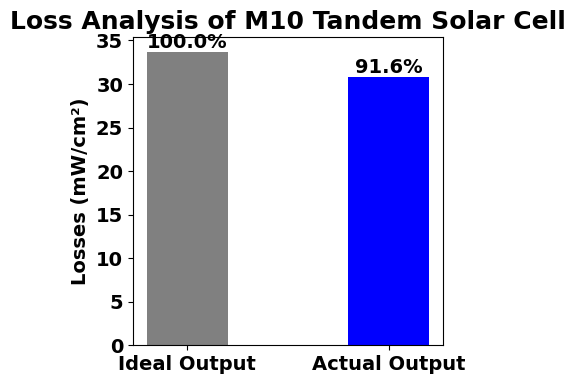

In [26]:
import matplotlib.pyplot as plt

# Define losses
losses = {'Ideal Output':normalized_ideal_output*1000,
    'Actual Output': normalized_v1_power*1000,
    }


# Ideal Output을 100%로 설정
ideal_output_value = losses['Ideal Output']

# 막대 그래프 생성
plt.figure(figsize=(4, 4))
bars = plt.bar(losses.keys(), losses.values(), color=[ 'gray', 'blue'] ,width=0.4)

# 각 막대 위에 Ideal Output에 대한 백분율 표시
for bar in bars:
    yval = bar.get_height()
    percentage = yval / ideal_output_value * 100  # Ideal Output 대비 비율 계산
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage:.1f}%', va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('Loss Analysis of M10 Tandem Solar Cell', fontsize=18, fontweight='bold')
plt.ylabel('Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

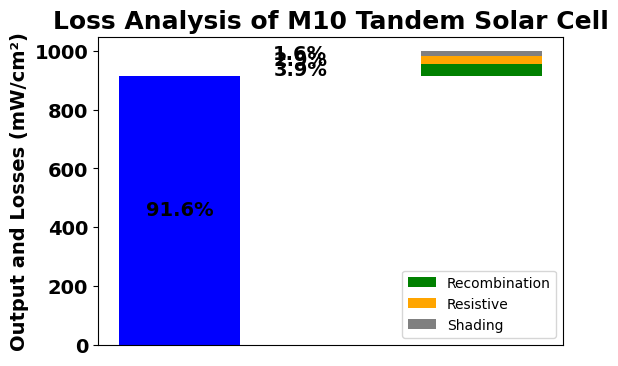

In [28]:
import matplotlib.pyplot as plt

# Define values
normalized_ideal_output = 1.0  # 가정한 값, 실제 데이터로 대체 필요
normalized_v1_power = 0.916  # 가정한 값, 실제 데이터로 대체 필요

# Define losses and sub-losses
total_losses = normalized_ideal_output - normalized_v1_power
shading_losses = 0.188 * total_losses
resistive_losses = 0.35 * total_losses
recombination_losses = 0.461 * total_losses

# 막대 그래프 생성
plt.figure(figsize=(6, 4))

# Actual Output 막대
bars_actual = plt.bar('Output', normalized_v1_power * 1000, color='blue', width=0.4)

# Sub-losses 막대, 각각 스택
bottom_height = normalized_v1_power * 1000
for loss, color, label in zip([recombination_losses, resistive_losses, shading_losses], ['green', 'orange', 'gray'], ['Recombination', 'Resistive', 'Shading']):
    plt.bar('Losses', loss * 1000, bottom=bottom_height, color=color, width=0.4, label=label)
    bottom_height += loss * 1000

# 막대 위에 백분율 표시
plt.text(bars_actual[0].get_x() + bars_actual[0].get_width() / 2, normalized_v1_power * 1000 / 2, f'{normalized_v1_power * 100:.1f}%', va='center', ha='center', fontsize=14, fontweight='bold')

# 손실에 대한 백분율 표시
bottom_height = normalized_v1_power * 1000
for loss, label in zip([recombination_losses, resistive_losses, shading_losses], ['Recombination', 'Resistive', 'Shading']):
    percentage = loss / normalized_ideal_output * 100
    plt.text(bars_actual[0].get_x() + bars_actual[0].get_width() * 1.5, bottom_height + (loss * 1000 / 2), f'{percentage:.1f}%', va='center', ha='center', fontsize=14, fontweight='bold')
    bottom_height += loss * 1000

plt.title('Loss Analysis of M10 Tandem Solar Cell', fontsize=18, fontweight='bold')
plt.ylabel('Output and Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks([])
plt.yticks(fontsize=14, fontweight='bold')
plt.legend()
plt.show()



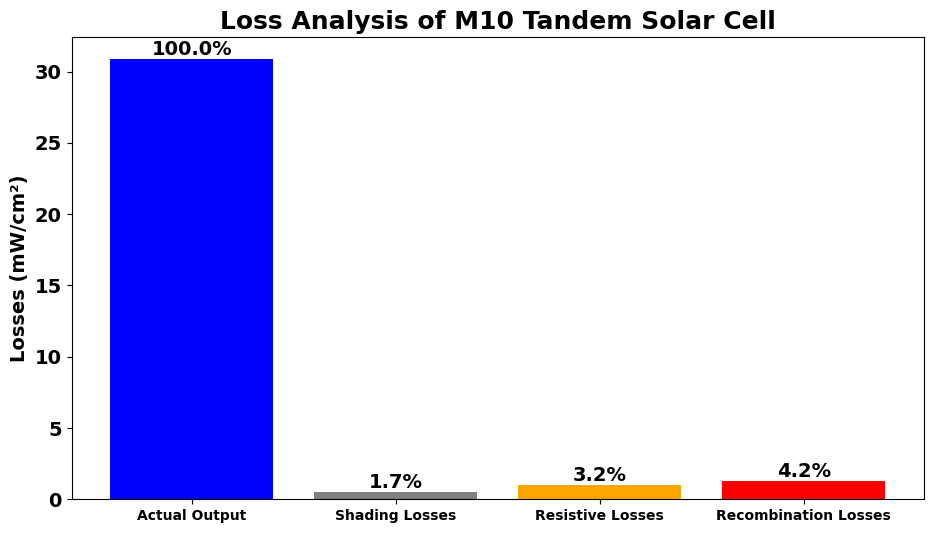

In [54]:
# Define losses
losses = {'Actual Output': normalized_v1_power * 1000,
          'Shading Losses': 0.5323,
          'Resistive Losses': normalized_total_resistive_power_loss * 1000,
          'Recombination Losses': normalized_total_recombination_power_loss * 1000}

# 총 손실 계산 (비율 계산을 위함)
actual_output_value = losses['Actual Output']

# 막대 그래프 생성
plt.figure(figsize=(11, 6))
bars = plt.bar(losses.keys(), losses.values(), color=['blue', 'gray', 'orange', 'red', 'green'])

# 각 막대 위에 Ideal Output에 대한 백분율 표시
for bar in bars:
    yval = bar.get_height()
    percentage = yval / actual_output_value * 100  # Ideal Output 대비 비율 계산
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage:.1f}%', va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('Loss Analysis of M10 Tandem Solar Cell', fontsize=18, fontweight='bold')
plt.ylabel('Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

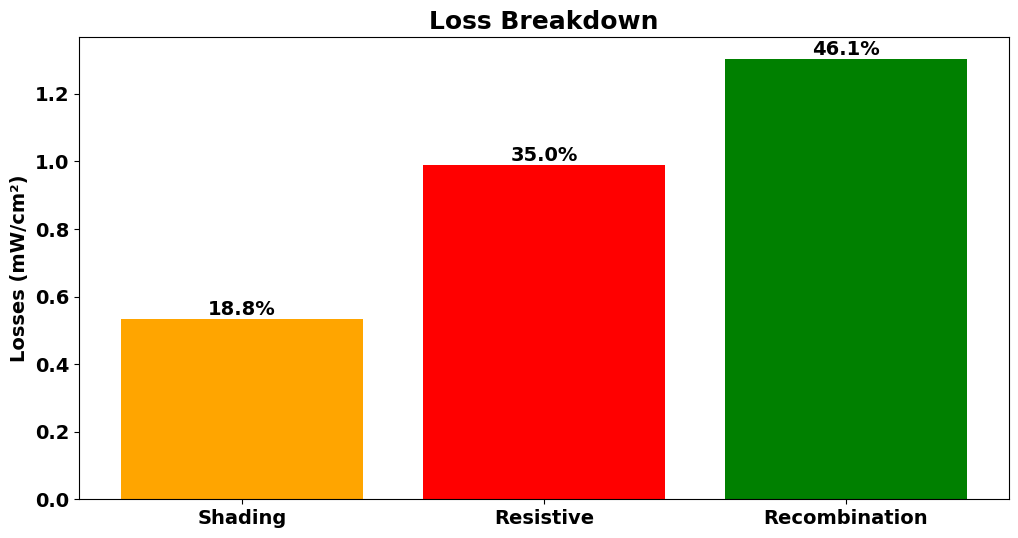

In [55]:
losses = {
    'Shading': 0.5323,
    'Resistive': normalized_total_resistive_power_loss*1000,
    'Recombination': normalized_total_recombination_power_loss*1000
}
# 총 손실 계산 (비율 계산을 위함)
total_loss = sum(losses.values())

# 막대 그래프 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(losses.keys(), losses.values(), color=[ 'orange', 'red', 'green'])

# 각 막대 위에 백분율 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval / total_loss * 100:.1f}%', va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('Loss Breakdown', fontsize=18, fontweight='bold')
plt.ylabel('Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()


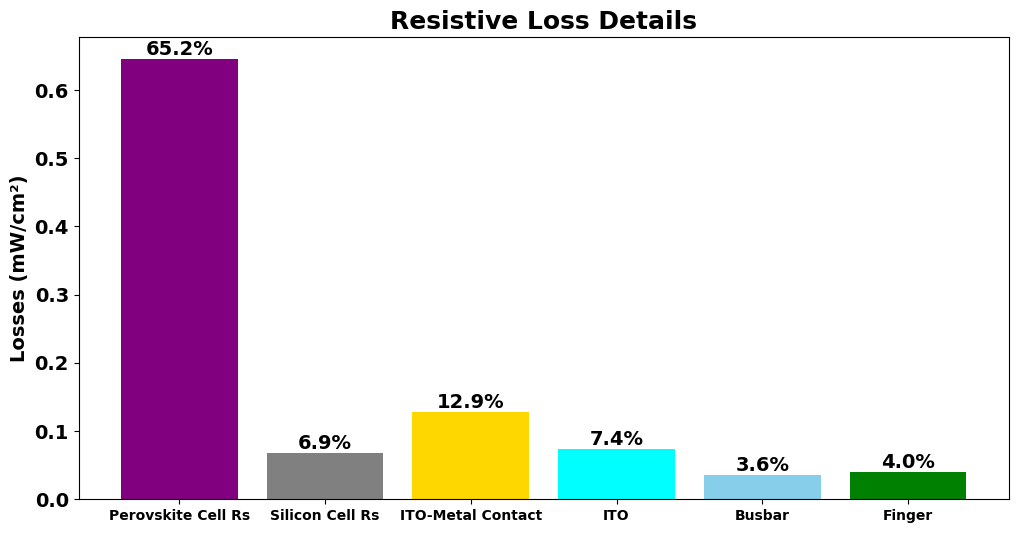

In [56]:
losses = { 'Perovskite Cell Rs':normalized_rs_top_loss*0.728142*1000, 'Silicon Cell Rs': normalized_rs_bot_loss*1000,
          'ITO-Metal Contact': normalized_rs_top_loss*0.14424*1000,
          'ITO' : normalized_rs_top_loss*0.083057*1000,
          'Busbar': normalized_busbar_loss*1000,
          'Finger': normalized_rs_top_loss*0.044562*1000}
        


# 총 손실 계산 (비율 계산을 위함)
total_loss = sum(losses.values())

# 막대 그래프 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(losses.keys(), losses.values(), color=[ 'purple', 'gray', 'gold', 'cyan', 'skyblue','green'])

# 각 막대 위에 백분율 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval / total_loss * 100:.1f}%', va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('Resistive Loss Details', fontsize=18, fontweight='bold')
plt.ylabel('Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

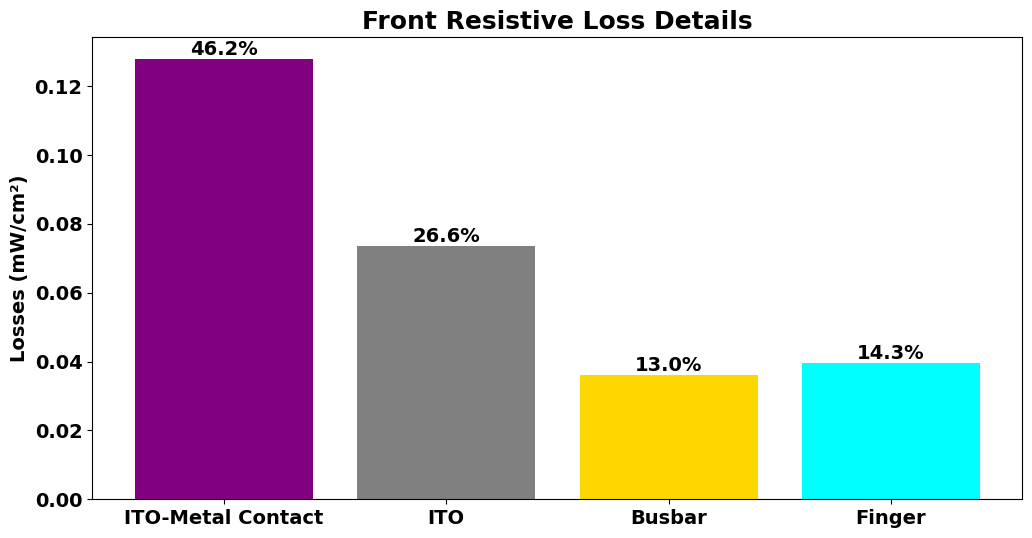

In [57]:
losses = {
          'ITO-Metal Contact': normalized_rs_top_loss*0.14424*1000,
          'ITO' : normalized_rs_top_loss*0.083057*1000,
          'Busbar': normalized_busbar_loss*1000,
          'Finger': normalized_rs_top_loss*0.044562*1000 }
        

# 총 손실 계산 (비율 계산을 위함)
total_loss = sum(losses.values())

# 막대 그래프 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(losses.keys(), losses.values(), color=[ 'purple', 'gray', 'gold', 'cyan', 'skyblue','green'])

# 각 막대 위에 백분율 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval / total_loss * 100:.1f}%', va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('Front Resistive Loss Details', fontsize=18, fontweight='bold')
plt.ylabel('Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()

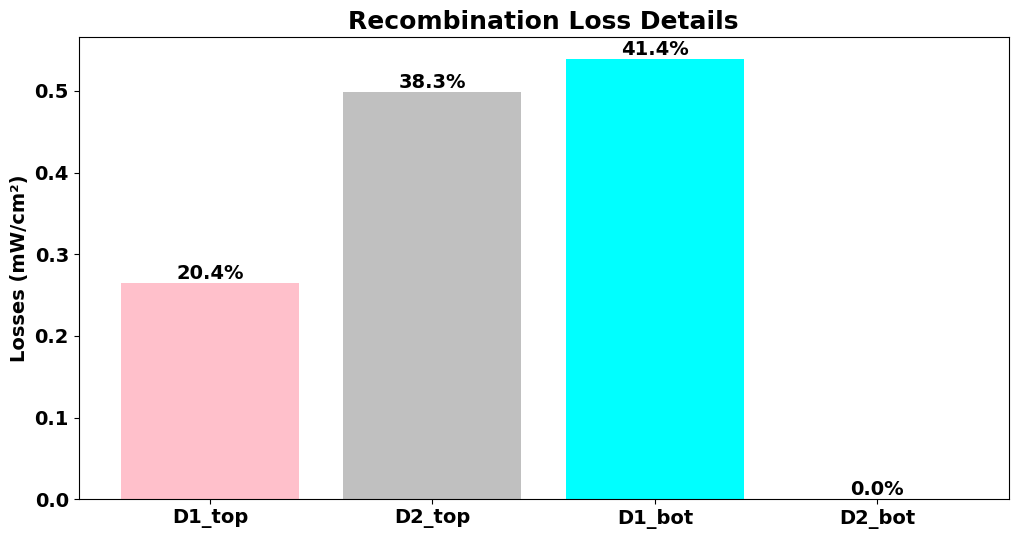

In [58]:
losses = {
        'D1_top': normalized_d1top_loss*1000,'D2_top': normalized_d2top_loss*1000,
          'D1_bot': normalized_d1bot_loss*1000,'D2_bot': normalized_d2bot_loss*1000
          }



# 총 손실 계산 (비율 계산을 위함)
total_loss = sum(losses.values())

# 막대 그래프 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(losses.keys(), losses.values(), color=[ 'pink', 'silver', 'cyan', 'white'])

# 각 막대 위에 백분율 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval / total_loss * 100:.1f}%', va='bottom', ha='center', fontsize=14, fontweight='bold')

plt.title('Recombination Loss Details', fontsize=18, fontweight='bold')
plt.ylabel('Losses (mW/cm²)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()